In [1]:
import os
import math
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import timedelta
from itertools import product
import torch
from torch import nn
import torch.optim as optim
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA
from torch.utils.data import Dataset, DataLoader
from transformers.optimization import Adafactor
from matplotlib import pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


## Data Preparation

#### electricity price

In [3]:
price = pd.read_csv('GB electricity price.csv') 
print(price)

              Country ISO3 Code       Datetime (UTC)     Datetime (Local)  \
0      United Kingdom       GBR  2016-06-29 23:00:00  2016-06-30 00:00:00   
1      United Kingdom       GBR  2016-06-30 00:00:00  2016-06-30 01:00:00   
2      United Kingdom       GBR  2016-06-30 01:00:00  2016-06-30 02:00:00   
3      United Kingdom       GBR  2016-06-30 02:00:00  2016-06-30 03:00:00   
4      United Kingdom       GBR  2016-06-30 03:00:00  2016-06-30 04:00:00   
...               ...       ...                  ...                  ...   
82124  United Kingdom       GBR  2025-11-11 19:00:00  2025-11-11 19:00:00   
82125  United Kingdom       GBR  2025-11-11 20:00:00  2025-11-11 20:00:00   
82126  United Kingdom       GBR  2025-11-11 21:00:00  2025-11-11 21:00:00   
82127  United Kingdom       GBR  2025-11-11 22:00:00  2025-11-11 22:00:00   
82128  United Kingdom       GBR  2025-11-11 23:00:00  2025-11-11 23:00:00   

       Price (EUR/MWhe)  
0                 35.72  
1                 35.49

In [4]:
price = price[["Datetime (UTC)", "Price (EUR/MWhe)"]].copy()
price["Datetime (UTC)"] = pd.to_datetime(price["Datetime (UTC)"])
start = "2021-04-01"
end   = "2024-12-31"
price = price[(price["Datetime (UTC)"] >= start) & (price["Datetime (UTC)"] <= end)]
price = price.set_index("Datetime (UTC)").asfreq("H")
print(price)

                     Price (EUR/MWhe)
Datetime (UTC)                       
2021-04-01 00:00:00             56.66
2021-04-01 01:00:00             56.04
2021-04-01 02:00:00             48.45
2021-04-01 03:00:00             49.72
2021-04-01 04:00:00             61.11
...                               ...
2024-12-30 20:00:00            125.77
2024-12-30 21:00:00            125.60
2024-12-30 22:00:00            106.81
2024-12-30 23:00:00             83.93
2024-12-31 00:00:00             66.18

[32881 rows x 1 columns]


/var/folders/h1/ws83qjt554q7qtqbb482sgg40000gn/T/ipykernel_66222/1231485602.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  price = price.set_index("Datetime (UTC)").asfreq("H")


#### carbon related data

In [5]:
data_folder = Path(".")
file_names = [
    "GB_2021_hourly.csv",
    "GB_2022_hourly.csv",
    "GB_2023_hourly.csv",
    "GB_2024_hourly.csv",
]

dfs = []
for fname in file_names:
    file_path = data_folder / fname
    print(f"读取文件: {file_path}")
    df = pd.read_csv(file_path)    
    dfs.append(df)

# 合并为一个大表
combined = pd.concat(dfs, ignore_index=True)
start = "2021-04-01"
end   = "2024-12-31"
combined = combined[(combined ["Datetime (UTC)"] >= start) & (combined ["Datetime (UTC)"] <= end)]
combined

读取文件: GB_2021_hourly.csv
读取文件: GB_2022_hourly.csv
读取文件: GB_2023_hourly.csv
读取文件: GB_2024_hourly.csv


,Datetime (UTC),Country,Zone name,Zone id,Carbon intensity gCO₂eq/kWh (direct),Carbon intensity gCO₂eq/kWh (Life cycle),Carbon-free energy percentage (CFE%),Renewable energy percentage (RE%),Data source,Data estimated,Data estimation method
2160,2021-04-01 00:00:00,Great Britain,Great Britain,GB,96.69,146.11,74.42,44.62,elexon.co.uk; nationalgrideso.com,False,NaN
2161,2021-04-01 01:00:00,Great Britain,Great Britain,GB,89.84,140.16,76.26,47.22,elexon.co.uk; nationalgrideso.com,False,NaN
2162,2021-04-01 02:00:00,Great Britain,Great Britain,GB,89.05,139.48,76.50,47.11,elexon.co.uk; nationalgrideso.com,False,NaN
2163,2021-04-01 03:00:00,Great Britain,Great Britain,GB,83.99,132.93,77.85,49.44,elexon.co.uk; nationalgrideso.com,False,NaN
2164,2021-04-01 04:00:00,Great Britain,Great Britain,GB,94.81,146.25,74.95,49.92,elexon.co.uk; nationalgrideso.com,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...
35035,2024-12-30 19:00:00,Great Britain,Great Britain,GB,91.65,140.78,76.69,62.42,elexon.co.uk; nationalgrideso.com,False,NaN
35036,2024-12-30 20:00:00,Great Britain,Great Britain,GB,80.54,127.49,78.94,64.12,elexon.co.uk; nationalgrideso.com,False,NaN
35037,2024-12-30 21:00:00,Great Britain,Great Britain,GB,62.51,104.25,83.88,68.26,elexon.co.uk; nationalgrideso.com,False,NaN
35038,2024-12-30 22:00:00,Great Britain,Great Britain,GB,51.36,89.81,87.03,70.64,elexon.co.uk; nationalgrideso.com,False,NaN


#### demand

In [6]:
demand = pd.read_csv("demand.csv")
demand["Datetime"] = pd.to_datetime(demand["Datetime"])
demand = demand[["Datetime", "Demand_Outturn"]]

demand["Hour"] = (demand["Datetime"] + pd.Timedelta(minutes=30)).dt.floor("H")

demand_hourly = (
    demand
    .groupby("Hour", as_index=False)["Demand_Outturn"]
    .mean()
)

demand = demand_hourly.rename(columns={"Hour": "Datetime"})
start = "2021-04-01"
end   = "2024-12-31"
demand = demand[(demand["Datetime"] >= start) & (demand["Datetime"] <= end)]
demand

/var/folders/h1/ws83qjt554q7qtqbb482sgg40000gn/T/ipykernel_66222/3721799294.py:1: DtypeWarning: Columns (14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  demand = pd.read_csv("demand.csv")
/var/folders/h1/ws83qjt554q7qtqbb482sgg40000gn/T/ipykernel_66222/3721799294.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  demand["Hour"] = (demand["Datetime"] + pd.Timedelta(minutes=30)).dt.floor("H")


,Datetime,Demand_Outturn
0,2021-04-01 01:00:00+00:00,20000.0
1,2021-04-01 02:00:00+00:00,20719.5
2,2021-04-01 03:00:00+00:00,20498.5
3,2021-04-01 04:00:00+00:00,19872.5
4,2021-04-01 05:00:00+00:00,19572.5
...,...,...
32873,2024-12-30 20:00:00+00:00,33048.5
32874,2024-12-30 21:00:00+00:00,30911.0
32875,2024-12-30 22:00:00+00:00,28277.0
32876,2024-12-30 23:00:00+00:00,25677.5


#### PV / temperature / wind

In [7]:
pv = pd.read_csv("pv-country-GB-nuts2-merra2.csv", comment='#')
start = "2021-04-01"
end   = "2024-12-31"
pv = pv[(pv["time"] >= start) & (pv["time"] <= end)]
print("筛选后行数:", len(pv))

pv_cols = [col for col in pv.columns if col.startswith("UK")]
print("英国区域列：")
print(pv_cols)

# 生成英国总光伏列（所有区域加总）
pv["UK_PV_Total"] = pv[pv_cols].sum(axis=1)
pv = pv[["time", "UK_PV_Total"]]

pv

筛选后行数: 32880
英国区域列：
['UKC1', 'UKC2', 'UKD1', 'UKD3', 'UKD4', 'UKD6', 'UKD7', 'UKE1', 'UKE2', 'UKE3', 'UKE4', 'UKF1', 'UKF2', 'UKF3', 'UKG1', 'UKG2', 'UKG3', 'UKH1', 'UKH2', 'UKH3', 'UKI3', 'UKI4', 'UKI5', 'UKI6', 'UKI7', 'UKJ1', 'UKJ2', 'UKJ3', 'UKJ4', 'UKK1', 'UKK2', 'UKK3', 'UKK4', 'UKL1', 'UKL2', 'UKM2', 'UKM3', 'UKM5', 'UKM6', 'UKN0']


,time,UK_PV_Total
361584,2021-04-01 00:00:00+00:00,0.0
361585,2021-04-01 01:00:00+00:00,0.0
361586,2021-04-01 02:00:00+00:00,0.0
361587,2021-04-01 03:00:00+00:00,0.0
361588,2021-04-01 04:00:00+00:00,0.0
...,...,...
394459,2024-12-30 19:00:00+00:00,0.0
394460,2024-12-30 20:00:00+00:00,0.0
394461,2024-12-30 21:00:00+00:00,0.0
394462,2024-12-30 22:00:00+00:00,0.0


In [8]:
temp = pd.read_csv("temperature_area_wtd-merra2.csv", comment='#')
start = "2021-04-01"
end   = "2024-12-31"
temp = temp[(temp["time"] >= start) & (temp["time"] <= end)]
print("筛选后行数:", len(temp))

temp_cols = [col for col in temp.columns if col.startswith("UK")]
print("英国区域列：")
print(temp_cols)

# 生成英国温度（所有区域平均）
temp["UK_temp_Avg"] = temp[temp_cols].mean(axis=1)
temp = temp[["time", "UK_temp_Avg"]]

temp

筛选后行数: 32880
英国区域列：
['UKC1', 'UKC2', 'UKD1', 'UKD3', 'UKD4', 'UKD6', 'UKD7', 'UKE1', 'UKE2', 'UKE3', 'UKE4', 'UKF1', 'UKF2', 'UKF3', 'UKG1', 'UKG2', 'UKG3', 'UKH1', 'UKH2', 'UKH3', 'UKI3', 'UKI4', 'UKI5', 'UKI6', 'UKI7', 'UKJ1', 'UKJ2', 'UKJ3', 'UKJ4', 'UKK1', 'UKK2', 'UKK3', 'UKK4', 'UKL1', 'UKL2', 'UKM5', 'UKM6', 'UKM7', 'UKM8', 'UKM9', 'UKN0']


,time,UK_temp_Avg
361584,2021-04-01 00:00:00+00:00,7.700220
361585,2021-04-01 01:00:00+00:00,6.976244
361586,2021-04-01 02:00:00+00:00,6.531561
361587,2021-04-01 03:00:00+00:00,6.309415
361588,2021-04-01 04:00:00+00:00,6.006439
...,...,...
394459,2024-12-30 19:00:00+00:00,6.880220
394460,2024-12-30 20:00:00+00:00,6.839976
394461,2024-12-30 21:00:00+00:00,6.788244
394462,2024-12-30 22:00:00+00:00,6.783878


In [9]:
wind = pd.read_csv("wind_speed_area_wtd-merra2.csv", comment='#')
start = "2021-04-01"
end   = "2024-12-31"
wind = wind[(wind["time"] >= start) & (wind["time"] <= end)]
print("筛选后行数:", len(wind))

wind_cols = [col for col in wind.columns if col.startswith("UK")]
print("英国区域列：")
print(wind_cols)

# 生成英国风速（所有区域平均）
wind["UK_wind_Avg"] = wind[wind_cols].mean(axis=1)
wind = wind[["time", "UK_wind_Avg"]]

wind

筛选后行数: 32880
英国区域列：
['UKC1', 'UKC2', 'UKD1', 'UKD3', 'UKD4', 'UKD6', 'UKD7', 'UKE1', 'UKE2', 'UKE3', 'UKE4', 'UKF1', 'UKF2', 'UKF3', 'UKG1', 'UKG2', 'UKG3', 'UKH1', 'UKH2', 'UKH3', 'UKI3', 'UKI4', 'UKI5', 'UKI6', 'UKI7', 'UKJ1', 'UKJ2', 'UKJ3', 'UKJ4', 'UKK1', 'UKK2', 'UKK3', 'UKK4', 'UKL1', 'UKL2', 'UKM5', 'UKM6', 'UKM7', 'UKM8', 'UKM9', 'UKN0']


,time,UK_wind_Avg
361584,2021-04-01 00:00:00+00:00,3.228195
361585,2021-04-01 01:00:00+00:00,3.529488
361586,2021-04-01 02:00:00+00:00,3.809756
361587,2021-04-01 03:00:00+00:00,4.089610
361588,2021-04-01 04:00:00+00:00,4.215829
...,...,...
394459,2024-12-30 19:00:00+00:00,3.796390
394460,2024-12-30 20:00:00+00:00,3.956317
394461,2024-12-30 21:00:00+00:00,4.144146
394462,2024-12-30 22:00:00+00:00,4.381634


#### create new data set

In [10]:
combined

,Datetime (UTC),Country,Zone name,Zone id,Carbon intensity gCO₂eq/kWh (direct),Carbon intensity gCO₂eq/kWh (Life cycle),Carbon-free energy percentage (CFE%),Renewable energy percentage (RE%),Data source,Data estimated,Data estimation method
2160,2021-04-01 00:00:00,Great Britain,Great Britain,GB,96.69,146.11,74.42,44.62,elexon.co.uk; nationalgrideso.com,False,NaN
2161,2021-04-01 01:00:00,Great Britain,Great Britain,GB,89.84,140.16,76.26,47.22,elexon.co.uk; nationalgrideso.com,False,NaN
2162,2021-04-01 02:00:00,Great Britain,Great Britain,GB,89.05,139.48,76.50,47.11,elexon.co.uk; nationalgrideso.com,False,NaN
2163,2021-04-01 03:00:00,Great Britain,Great Britain,GB,83.99,132.93,77.85,49.44,elexon.co.uk; nationalgrideso.com,False,NaN
2164,2021-04-01 04:00:00,Great Britain,Great Britain,GB,94.81,146.25,74.95,49.92,elexon.co.uk; nationalgrideso.com,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...
35035,2024-12-30 19:00:00,Great Britain,Great Britain,GB,91.65,140.78,76.69,62.42,elexon.co.uk; nationalgrideso.com,False,NaN
35036,2024-12-30 20:00:00,Great Britain,Great Britain,GB,80.54,127.49,78.94,64.12,elexon.co.uk; nationalgrideso.com,False,NaN
35037,2024-12-30 21:00:00,Great Britain,Great Britain,GB,62.51,104.25,83.88,68.26,elexon.co.uk; nationalgrideso.com,False,NaN
35038,2024-12-30 22:00:00,Great Britain,Great Britain,GB,51.36,89.81,87.03,70.64,elexon.co.uk; nationalgrideso.com,False,NaN


In [11]:
# 统一时间列名称
#price = price.rename(columns={"Datetime (UTC)": "Datetime"})
combined = combined.rename(columns={"Datetime (UTC)": "Datetime"})
demand = demand.rename(columns={"Datetime": "Datetime"})
pv = pv.rename(columns={"time": "Datetime"})
temp = temp.rename(columns={"time": "Datetime"})
wind = wind.rename(columns={"time": "Datetime"})

price = price.rename_axis("Datetime").reset_index()

df_list = [price, combined, demand, pv, temp, wind]
for df in df_list:
    s = pd.to_datetime(df["Datetime"], utc=True)
    df["Datetime"] = s.dt.tz_convert(None)
    df.sort_values("Datetime", inplace=True)

data = price.copy()

data = data.merge(combined, on="Datetime", how="inner")
data = data.merge(demand, on="Datetime", how="inner")
data = data.merge(pv, on="Datetime", how="inner")
data = data.merge(temp, on="Datetime", how="inner")
data = data.merge(wind, on="Datetime", how="inner")
data.to_csv("GB_data_2021_2024_hourly.csv", index=False)
data

,Datetime,Price (EUR/MWhe),Country,Zone name,Zone id,Carbon intensity gCO₂eq/kWh (direct),Carbon intensity gCO₂eq/kWh (Life cycle),Carbon-free energy percentage (CFE%),Renewable energy percentage (RE%),Data source,Data estimated,Data estimation method,Demand_Outturn,UK_PV_Total,UK_temp_Avg,UK_wind_Avg
0,2021-04-01 01:00:00,56.04,Great Britain,Great Britain,GB,89.84,140.16,76.26,47.22,elexon.co.uk; nationalgrideso.com,False,NaN,20000.0,0.0,6.976244,3.529488
1,2021-04-01 02:00:00,48.45,Great Britain,Great Britain,GB,89.05,139.48,76.50,47.11,elexon.co.uk; nationalgrideso.com,False,NaN,20719.5,0.0,6.531561,3.809756
2,2021-04-01 03:00:00,49.72,Great Britain,Great Britain,GB,83.99,132.93,77.85,49.44,elexon.co.uk; nationalgrideso.com,False,NaN,20498.5,0.0,6.309415,4.089610
3,2021-04-01 04:00:00,61.11,Great Britain,Great Britain,GB,94.81,146.25,74.95,49.92,elexon.co.uk; nationalgrideso.com,False,NaN,19872.5,0.0,6.006439,4.215829
4,2021-04-01 05:00:00,73.02,Great Britain,Great Britain,GB,114.73,170.97,69.62,46.32,elexon.co.uk; nationalgrideso.com,False,NaN,19572.5,0.0,5.664317,4.254146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32872,2024-12-30 19:00:00,132.86,Great Britain,Great Britain,GB,91.65,140.78,76.69,62.42,elexon.co.uk; nationalgrideso.com,False,NaN,34321.5,0.0,6.880220,3.796390
32873,2024-12-30 20:00:00,125.77,Great Britain,Great Britain,GB,80.54,127.49,78.94,64.12,elexon.co.uk; nationalgrideso.com,False,NaN,33048.5,0.0,6.839976,3.956317
32874,2024-12-30 21:00:00,125.60,Great Britain,Great Britain,GB,62.51,104.25,83.88,68.26,elexon.co.uk; nationalgrideso.com,False,NaN,30911.0,0.0,6.788244,4.144146
32875,2024-12-30 22:00:00,106.81,Great Britain,Great Britain,GB,51.36,89.81,87.03,70.64,elexon.co.uk; nationalgrideso.com,False,NaN,28277.0,0.0,6.783878,4.381634


### features engineering

#### lagged

In [12]:
# Price lag：过去 24 小时 + 上周同一时刻
for lag in range(1, 25):  # 1h--24h
    data[f"Price_lag_{lag}h"] = data["Price (EUR/MWhe)"].shift(lag)

df["Price_lag_168h"] = data["Price (EUR/MWhe)"].shift(24 * 7)  # 一周前

# Demand lag：过去 24 小时
for lag in range(1, 25):
    data[f"Demand_lag_{lag}h"] = data["Demand_Outturn"].shift(lag)

# PV lag：过去 24 小时
for lag in range(1, 25):
    data[f"PV_lag_{lag}h"] = data["UK_PV_Total"].shift(lag)


#### rolling

In [13]:
# 过去 7 天 & 30 天滚动均值（小时数据 → 7*24 / 30*24）
data["Price_roll_mean_7d"]  = data["Price (EUR/MWhe)"].rolling(window=24*7).mean()
data["Price_roll_mean_30d"] = data["Price (EUR/MWhe)"].rolling(window=24*30).mean()

#### hourly / weekly / seasonal

In [14]:
data["Datetime"] = pd.to_datetime(data["Datetime"])
data = data.sort_values("Datetime").set_index("Datetime")
hours = data.index.hour
dow   = data.index.dayofweek  # 0=周一
month = data.index.month

data["hour_sin"]  = np.sin(2 * np.pi * hours / 24)
data["hour_cos"]  = np.cos(2 * np.pi * hours / 24)
data["dow_sin"]   = np.sin(2 * np.pi * dow / 7)
data["dow_cos"]   = np.cos(2 * np.pi * dow / 7)
data["month_sin"] = np.sin(2 * np.pi * month / 12)
data["month_cos"] = np.cos(2 * np.pi * month / 12)

In [15]:
data

,Price (EUR/MWhe),Country,Zone name,Zone id,Carbon intensity gCO₂eq/kWh (direct),Carbon intensity gCO₂eq/kWh (Life cycle),Carbon-free energy percentage (CFE%),Renewable energy percentage (RE%),Data source,Data estimated,...,PV_lag_23h,PV_lag_24h,Price_roll_mean_7d,Price_roll_mean_30d,hour_sin,hour_cos,dow_sin,dow_cos,month_sin,month_cos
Datetime,,,,,,,,,,,,,,,,,,,,,
2021-04-01 01:00:00,56.04,Great Britain,Great Britain,GB,89.84,140.16,76.26,47.22,elexon.co.uk; nationalgrideso.com,False,...,NaN,NaN,NaN,NaN,0.258819,0.965926,0.433884,-0.900969,8.660254e-01,-0.5
2021-04-01 02:00:00,48.45,Great Britain,Great Britain,GB,89.05,139.48,76.50,47.11,elexon.co.uk; nationalgrideso.com,False,...,NaN,NaN,NaN,NaN,0.500000,0.866025,0.433884,-0.900969,8.660254e-01,-0.5
2021-04-01 03:00:00,49.72,Great Britain,Great Britain,GB,83.99,132.93,77.85,49.44,elexon.co.uk; nationalgrideso.com,False,...,NaN,NaN,NaN,NaN,0.707107,0.707107,0.433884,-0.900969,8.660254e-01,-0.5
2021-04-01 04:00:00,61.11,Great Britain,Great Britain,GB,94.81,146.25,74.95,49.92,elexon.co.uk; nationalgrideso.com,False,...,NaN,NaN,NaN,NaN,0.866025,0.500000,0.433884,-0.900969,8.660254e-01,-0.5
2021-04-01 05:00:00,73.02,Great Britain,Great Britain,GB,114.73,170.97,69.62,46.32,elexon.co.uk; nationalgrideso.com,False,...,NaN,NaN,NaN,NaN,0.965926,0.258819,0.433884,-0.900969,8.660254e-01,-0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-30 19:00:00,132.86,Great Britain,Great Britain,GB,91.65,140.78,76.69,62.42,elexon.co.uk; nationalgrideso.com,False,...,0.0,0.0,113.189524,110.779389,-0.965926,0.258819,0.000000,1.000000,-2.449294e-16,1.0
2024-12-30 20:00:00,125.77,Great Britain,Great Britain,GB,80.54,127.49,78.94,64.12,elexon.co.uk; nationalgrideso.com,False,...,0.0,0.0,113.230238,110.792625,-0.866025,0.500000,0.000000,1.000000,-2.449294e-16,1.0
2024-12-30 21:00:00,125.60,Great Britain,Great Britain,GB,62.51,104.25,83.88,68.26,elexon.co.uk; nationalgrideso.com,False,...,0.0,0.0,113.284167,110.809306,-0.707107,0.707107,0.000000,1.000000,-2.449294e-16,1.0


In [16]:
# 基础变量
base_cols = ["Price (EUR/MWhe)", "Demand_Outturn", "UK_PV_Total", "UK_temp_Avg", "UK_wind_Avg"]

# 所有 lag 特征
lag_cols = [c for c in data.columns if "lag_" in c]

# 滚动特征
roll_cols = [c for c in data.columns if "roll_mean" in c]

# seasonal 特征
season_cols = [c for c in data.columns if c.endswith(("_sin", "_cos"))]

feature_cols = base_cols + lag_cols + roll_cols + season_cols

print("特征列数量:", len(feature_cols))

特征列数量: 85


In [17]:
df_feat = data[feature_cols].dropna().copy()
print("特征表形状:", df_feat.shape)
df_feat.head()

特征表形状: (32158, 85)


,Price (EUR/MWhe),Demand_Outturn,UK_PV_Total,UK_temp_Avg,UK_wind_Avg,Price_lag_1h,Price_lag_2h,Price_lag_3h,Price_lag_4h,Price_lag_5h,...,PV_lag_23h,PV_lag_24h,Price_roll_mean_7d,Price_roll_mean_30d,hour_sin,hour_cos,dow_sin,dow_cos,month_sin,month_cos
Datetime,,,,,,,,,,,,,,,,,,,,,
2021-05-01 00:00:00,73.37,26102.0,0.0,3.442171,1.216390,73.10,83.97,87.22,101.07,109.63,...,0.000,0.0,76.832738,76.403653,0.000000,1.000000,-0.974928,-0.222521,0.5,-0.866025
2021-05-01 01:00:00,73.75,23881.5,0.0,2.960122,1.246463,73.37,73.10,83.97,87.22,101.07,...,0.000,0.0,76.852917,76.428250,0.258819,0.965926,-0.974928,-0.222521,0.5,-0.866025
2021-05-01 02:00:00,69.71,23634.5,0.0,2.533707,1.297512,73.75,73.37,73.10,83.97,87.22,...,0.000,0.0,76.869405,76.457778,0.500000,0.866025,-0.974928,-0.222521,0.5,-0.866025
2021-05-01 03:00:00,66.17,23422.0,0.0,2.265463,1.375927,69.71,73.75,73.37,73.10,83.97,...,0.000,0.0,76.870893,76.480625,0.707107,0.707107,-0.974928,-0.222521,0.5,-0.866025
2021-05-01 04:00:00,64.69,22791.0,0.0,2.180171,1.459317,66.17,69.71,73.75,73.37,73.10,...,1.333,0.0,76.861488,76.485597,0.866025,0.500000,-0.974928,-0.222521,0.5,-0.866025


#### RF降维

In [18]:
target_col = "Price (EUR/MWhe)"
df_num = df_feat.select_dtypes(include=[np.number]).copy()
feature_cols = [c for c in df_num.columns if c != target_col]
print("原始特征个数:", len(feature_cols))

X = df_num[feature_cols]
y = df_num[target_col].values.ravel()   

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
)

rf.fit(X, y)

importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=feature_cols).sort_values(ascending=False)

feat_imp.head(20)

原始特征个数: 84


Price_lag_1h           0.897789
Price_lag_2h           0.013812
Price_lag_23h          0.012851
Price_lag_24h          0.007685
Price_lag_13h          0.004306
Demand_lag_11h         0.004293
Price_lag_22h          0.003235
Price_lag_3h           0.003219
UK_wind_Avg            0.003161
Price_lag_14h          0.002913
Price_lag_9h           0.002632
Price_lag_12h          0.002512
Price_lag_21h          0.001633
hour_cos               0.001535
Price_lag_11h          0.001372
Price_lag_8h           0.001342
UK_temp_Avg            0.001338
Demand_lag_22h         0.001307
Price_roll_mean_30d    0.001262
Demand_lag_10h         0.001223
dtype: float64

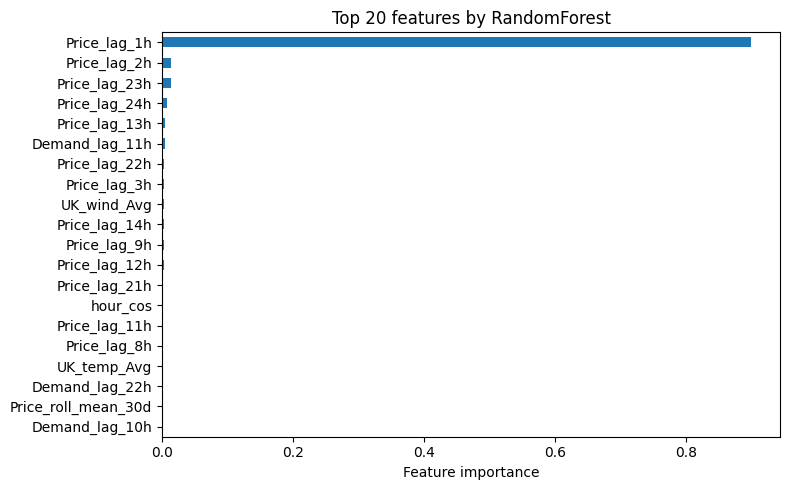

In [19]:
plt.figure(figsize=(8, 5))
feat_imp.head(20).plot(kind="barh")
plt.gca().invert_yaxis()
plt.xlabel("Feature importance")
plt.title("Top 20 features by RandomForest")
plt.tight_layout()
plt.show()

In [20]:
# 特征分类
price_feats = [c for c in feat_imp.index if c.startswith("Price_lag_")]
seasonal_feats = [c for c in feat_imp.index if c.startswith(("hour_", "dow_", "month_"))]
exog_feats = [c for c in feat_imp.index
              if c not in price_feats and c not in seasonal_feats]

# importance
price_feats_sorted = [c for c in feat_imp.index if c in price_feats]
exog_feats_sorted  = [c for c in feat_imp.index if c in exog_feats]

# 选价格滞后和外生特征
K_price = 7  
M_exog  = 2 

top_price = price_feats_sorted[:K_price]
top_exog  = exog_feats_sorted[:M_exog]

# 最终保留的特征
target_col = "Price (EUR/MWhe)"

selected_feats = [target_col] + top_price + top_exog + seasonal_feats

print("价格滞后保留:", top_price)
print("外生保留:", top_exog)
print("季节性:", seasonal_feats)
print("总特征数:", len(selected_feats))


价格滞后保留: ['Price_lag_1h', 'Price_lag_2h', 'Price_lag_23h', 'Price_lag_24h', 'Price_lag_13h', 'Price_lag_22h', 'Price_lag_3h']
外生保留: ['Demand_lag_11h', 'UK_wind_Avg']
季节性: ['hour_cos', 'hour_sin', 'dow_cos', 'dow_sin', 'month_sin', 'month_cos']
总特征数: 16


In [21]:
selected_feats

['Price (EUR/MWhe)',
 'Price_lag_1h',
 'Price_lag_2h',
 'Price_lag_23h',
 'Price_lag_24h',
 'Price_lag_13h',
 'Price_lag_22h',
 'Price_lag_3h',
 'Demand_lag_11h',
 'UK_wind_Avg',
 'hour_cos',
 'hour_sin',
 'dow_cos',
 'dow_sin',
 'month_sin',
 'month_cos']

In [22]:
df_features = df_feat[selected_feats]
df_features.to_csv("GB_df_features.csv", index=False)

#### DataLoader

In [23]:
# new ElectricDataset

class ElectricDataset(Dataset):
    def __init__(self, data: pd.DataFrame, sequence_length: int, evaluate: bool = False):
        super().__init__()
        # data: 已经归一化、只包含 selected_feats 的 DataFrame
        self.data = torch.from_numpy(data.to_numpy()).float()  # [T, 15]
        self.seq_len = sequence_length                         # 72
        self.evaluate = evaluate
        self.horizon = 24

    def __len__(self):
        T = self.data.shape[0]
        if self.evaluate:
            # 每 24 小时滑动一个样本（按天评估）
            return (T - self.seq_len) // self.horizon
        else:
            # 每小时滑动，最后一个样本的起点是 T - (seq_len + 24)
            return T - self.seq_len - self.horizon + 1

    def __getitem__(self, idx):
        # 计算窗口起点
        if self.evaluate:
            start = 24 * idx
        else:
            start = idx

        end = start + self.seq_len + self.horizon   # 不包含 end
        window = self.data[start:end]               # [seq_len + 24, 15]

        hist = window[: self.seq_len]               # [seq_len, 15]
        future = window[self.seq_len :]             # [24, 15]

        # 第 0 列是价格，1: 是 14 个外生
        values = hist[:, [0]]                       # [seq_len, 1]
        features = hist[:, 1:]                      # [seq_len, 14]
        y = future[:, 0]                            # [24]

        return values, features, y


In [23]:
class ElectricDataset(Dataset):
    def __init__(self, data: pd.DataFrame, sequence_length: int, evaluate: bool = False):
        super().__init__()
        self.data = torch.from_numpy(data.to_numpy()).float()
        self.seq_len = sequence_length
        self.evaluate = evaluate

    def __len__(self):
        if self.evaluate:
            return (self.data.shape[0] - self.seq_len) // 24
        else:
            return self.data.shape[0] - self.seq_len - 23

    def __getitem__(self, idx):
        # 输出长度 = seq_len + 24（未来 24 小时）
        if self.evaluate:
            sl = slice(24 * idx, 24 * idx + self.seq_len + 24)
        else:
            sl = slice(idx, idx + self.seq_len + 24)
        return self.data[sl]

In [24]:
DATA_PATH = "GB_df_features.csv"
SEQ_LEN = 72      # 3 天历史
BATCH_SIZE = 64


def make_dataloaders_from_csv(
    csv_path: str,
    seq_len: int = 72,
    batch_size: int = 64,
):
    # 读入特征数据（已经是 selected_feats 这些列）
    df_feat = pd.read_csv(csv_path)

    n = len(df_feat)
    test_hours = 365 * 24           # 最后 1 年做测试
    val_hours = 6 * 7 * 24          # 倒数前 6 周做验证（你原注释写 42*7*24）

    # 先把 train+val 和 test 割开
    df_train_val = df_feat.iloc[: n - test_hours].copy()
    df_test = df_feat.iloc[n - test_hours :].copy()

    # 测试集前面加 seq_len 历史（用于构造窗口）
    df_test = pd.concat([df_train_val.iloc[-seq_len:], df_test], axis=0)

    # ===== 归一化（只在 train_val 上算 mean/std）=====
    means = df_train_val.mean()
    stds = df_train_val.std()

    df_train_val_norm = (df_train_val - means) / stds
    df_test_norm = (df_test - means) / stds

    # ===== 再从 train_val_norm 中切出 train / val =====
    df_train = df_train_val_norm.iloc[: -val_hours].copy()
    df_val   = df_train_val_norm.iloc[-val_hours:].copy()

    # 验证集前面也加 seq_len 历史
    df_val = pd.concat([df_train.iloc[-seq_len:], df_val], axis=0)

    # ===== 构造 Dataset & DataLoader =====
    train_ds = ElectricDataset(df_train, seq_len, evaluate=False)
    val_ds   = ElectricDataset(df_val,   seq_len, evaluate=True)
    test_ds  = ElectricDataset(df_test_norm, seq_len, evaluate=True)

    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True, drop_last=True
    )
    val_loader = DataLoader(
        val_ds, batch_size=batch_size, shuffle=False, drop_last=False
    )
    test_loader = DataLoader(
        test_ds, batch_size=1, shuffle=False, drop_last=False
    )

    # 这里的 index 没有 Datetime，是 RangeIndex；如果后面要和时间对齐，
    # 可以单独保留一个时间序列 DataFrame 再用它的 index。
    return train_loader, val_loader, test_loader, means, stds


In [24]:
DATA_PATH = "GB_df_features.csv"
SEQ_LEN = 72      # 3 天历史
BATCH_SIZE = 64

def make_dataloaders_from_csv(
    csv_path: str,
    seq_len: int = 72,
    batch_size: int = 64,
):
#    df = pd.read_csv(csv_path, parse_dates=["Datetime"])
#    df = df.set_index("Datetime")

#    df_vars = df[["Price (EUR/MWhe)", "Demand_Outturn", "UK_PV_Total", 
#                  "Carbon-free energy percentage (CFE%)", "Renewable energy percentage (RE%)", 
#                  "UK_temp_Avg", "UK_wind_Avg", "Carbon intensity gCO₂eq/kWh (direct)"]].copy()

    # 划分 train / val / test
    n = len(df_feat)
    test_hours = 365 * 24           # 最后1年做测试
    val_hours = 42 * 7 * 24         # 倒数前6周做验证（和论文一致）

    df_train_val = df_feat.iloc[: n - test_hours]
    df_test = df_feat.iloc[n - test_hours :]

    # 测试集前面加 seq_len 历史
    df_test = pd.concat([df_train_val.iloc[-seq_len:], df_test], axis=0)

    # 归一化
    means = df_train_val.mean()
    stds = df_train_val.std()
    df_train_val_norm = (df_train_val - means) / stds
    df_test_norm = (df_test - means) / stds

    # split train_val
    df_train = df_train_val_norm.iloc[: -val_hours]
    df_val = df_train_val_norm.iloc[-val_hours:]

    # 验证集前面同样加 seq_len 历史
    df_val = pd.concat([df_train.iloc[-seq_len:], df_val], axis=0)

    # 构造 Dataset & DataLoader
    train_ds = ElectricDataset(df_train, seq_len)
    val_ds = ElectricDataset(df_val, seq_len, evaluate=True)
    test_ds = ElectricDataset(df_test_norm, seq_len, evaluate=True)

    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True, drop_last=True
    )
    val_loader = DataLoader(
        val_ds, batch_size=batch_size, shuffle=False, drop_last=False
    )
    test_loader = DataLoader(
        test_ds, batch_size=1, shuffle=False, drop_last=False
    )

    return train_loader, val_loader, test_loader, means, stds, df_test.index


train_loader, val_loader, test_loader, price_mean_std, price_std_std, test_index = make_dataloaders_from_csv(
    DATA_PATH, seq_len=SEQ_LEN, batch_size=BATCH_SIZE
)

price_mean = float( price_mean_std["Price (EUR/MWhe)"])
price_std = float(price_std_std["Price (EUR/MWhe)"])

In [25]:
# 位置编码
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        position = torch.arange(0, max_len).unsqueeze(1)  # [max_len, 1]
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer("pe", pe)  # 不参与训练

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [batch, seq_len, d_model]
        x = x + self.pe[: x.size(1)]
        return self.dropout(x)

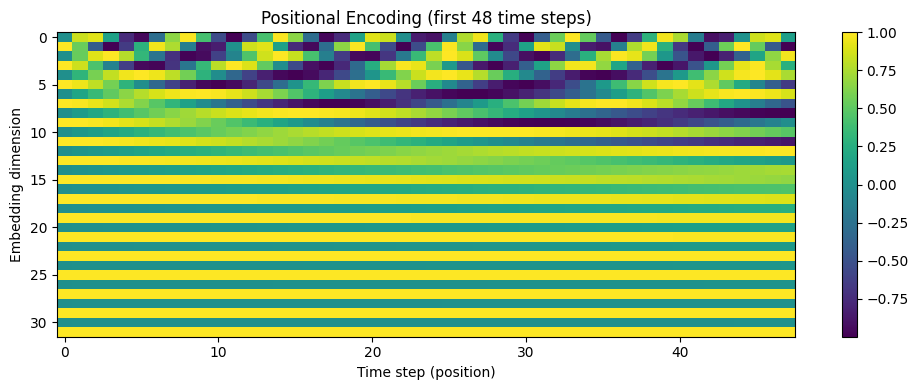

In [26]:
# 热力图看前48个时间步的编码
d_model = 32
max_len = 500
pe_layer = PositionalEncoding(d_model=d_model, max_len=max_len)

pe_matrix = pe_layer.pe[:48].detach().cpu().numpy()  # [seq_len, d_model]

plt.figure(figsize=(10, 4))
plt.imshow(pe_matrix.T, aspect="auto")
plt.xlabel("Time step (position)")
plt.ylabel("Embedding dimension")
plt.title("Positional Encoding (first 48 time steps)")
plt.colorbar()
plt.tight_layout()
plt.show()

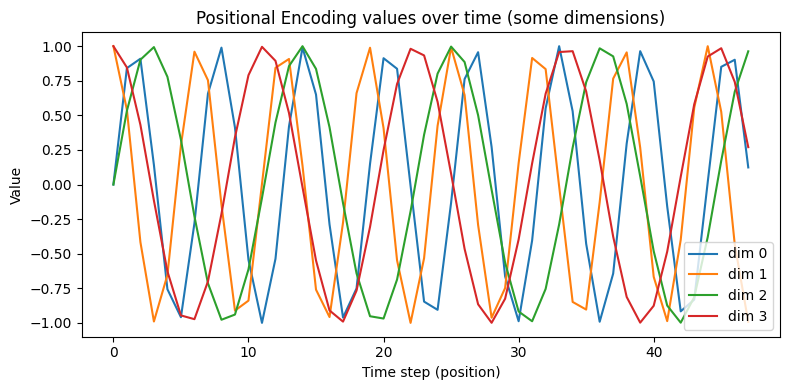

In [27]:
# 折线图看某几个维度随时间如何变化
plt.figure(figsize=(8, 4))

positions = np.arange(0, 48)  # 前 48 个小时
for dim in [0, 1, 2, 3]:      # 看前 4 个维度
    plt.plot(positions, pe_matrix[:, dim], label=f"dim {dim}")

plt.xlabel("Time step (position)")
plt.ylabel("Value")
plt.title("Positional Encoding values over time (some dimensions)")
plt.legend()
plt.tight_layout()
plt.show()


## Model

### new transformer

In [28]:
class BaseDailyElectricTransformer1(torch.nn.Module):
    def __init__(
        self,
        exog_dim: int,        
        embedding_dim: int = 32,
        num_heads: int = 8,
        dim_feedforward: int = 128,
        num_layers: int = 2,
        normalize_first: bool = False,
        dropout: float = 0.1,
        activation: str = "relu",
    ):
        """
        exog_dim:   每个小时的外生特征数
        """
        super().__init__()

        if activation == "relu":
            act = torch.nn.ReLU()
        else:
            act = torch.nn.GELU()

        self.exog_dim = exog_dim

        self.values_embeddings = torch.nn.Sequential(
            torch.nn.Linear(24, embedding_dim),
            act,
        )

        self.positional_encoding = PositionalEncoding(embedding_dim)

        encoder_layer = torch.nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
            norm_first=normalize_first,
            activation=activation,
        )
        self.transformer_encoder = torch.nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers
        )

        # 外生特征不再写死为48，而是 24 * exog_dim
        self.features_embeddings = torch.nn.Sequential(
            torch.nn.Linear(24 * exog_dim, embedding_dim),
            act,
        )

        # MLP 输出 24 小时价格
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(2 * embedding_dim, embedding_dim),
            act,
            torch.nn.Dropout(dropout),
            torch.nn.Linear(embedding_dim, 24),
        )

    def forward(self, values: torch.Tensor, features: torch.Tensor) -> torch.Tensor:
        """
        values:   [batch, seq_len, 1]           （主价格序列，seq_len 必须是 24 的倍数，如 96）
        features: [batch, seq_len, exog_dim]    （外生 + lag + seasonal，全都在这里）
        返回:
            [batch, 24] （未来 24 小时电价）
        """
        B, seq_len, _ = values.shape
        assert seq_len % 24 == 0, "seq_len 必须是 24 的倍数"
        assert features.shape[1] == seq_len
        assert features.shape[2] == self.exog_dim

        n_days = seq_len // 24

        # 过去价格 → 每 24 小时一组
        # [B, seq_len, 1] → [B, n_days, 24]
        values = values.reshape(B, n_days, 24)
        values_emb = self.values_embeddings(values)  # [B, n_days, d]

        x = self.positional_encoding(values_emb)
        x = self.transformer_encoder(x)              # [B, n_days, d]

        # 特征部分：
        # [B, seq_len, exog_dim] → [B, n_days, 24*exog_dim]
        features = features.reshape(B, n_days, 24 * self.exog_dim)
        feat_emb = self.features_embeddings(features)  # [B, n_days, d]

        # 拼接
        mlp_in = torch.cat([feat_emb, x], dim=2)       # [B, n_days, 2d]
        out_seq = self.mlp(mlp_in)                     # [B, n_days, 24]

        # 只取最后一天的 24 小时预测
        return out_seq[:, -1, :]                       # [B, 24]


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_exog = len(df_feat.columns) - 1   # = 14
model1 = BaseDailyElectricTransformer1(
    exog_dim=n_exog,
    embedding_dim=32,
    num_heads=8,
    dim_feedforward=128,
    num_layers=2,
    dropout=0.1,
    activation="relu",
).to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-3)


def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for values, features, y in loader:
        values   = values.to(device)   # [B, seq_len, 1]
        features = features.to(device) # [B, seq_len, 14]
        y        = y.to(device)        # [B, 24]

        optimizer.zero_grad()
        y_pred = model(values, features)  # [B, 24]
        loss = criterion(y_pred, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item() * values.size(0)
    return total_loss / len(loader.dataset)


@torch.no_grad()
def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    for values, features, y in loader:
        values   = values.to(device)
        features = features.to(device)
        y        = y.to(device)

        y_pred = model(values, features)
        loss = criterion(y_pred, y)
        total_loss += loss.item() * values.size(0)
    return total_loss / len(loader.dataset)


In [30]:
train_loader, val_loader, test_loader, means, stds = make_dataloaders_from_csv(
    DATA_PATH, seq_len=SEQ_LEN, batch_size=BATCH_SIZE
)

price_mean = means["Price (EUR/MWhe)"]
price_std  = stds["Price (EUR/MWhe)"]


In [31]:
# 取一个 batch 看一下形状
values, features, y = next(iter(train_loader))

print("values.shape   =", values.shape)    # 期待 [B, seq_len, 1]
print("features.shape =", features.shape)  # 期待 [B, seq_len, 14]
print("y.shape        =", y.shape)        # 期待 [B, 24]

B, seq_len, n_feat_total = values.shape[0], values.shape[1], features.shape[2]
n_exog = features.shape[-1]   # 14
print("seq_len =", seq_len, "n_exog =", n_exog)


values.shape   = torch.Size([64, 72, 1])
features.shape = torch.Size([64, 72, 15])
y.shape        = torch.Size([64, 24])
seq_len = 72 n_exog = 15


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BaseDailyElectricTransformer1(
    exog_dim=n_exog,
    embedding_dim=32,
    num_heads=8,
    dim_feedforward=128,
    num_layers=2,
    dropout=0.1,
    activation="relu",
).to(device)

with torch.no_grad():
    y_pred = model(values.to(device), features.to(device))
print("y_pred.shape =", y_pred.shape)   # 期待 [B, 24]


y_pred.shape = torch.Size([64, 24])


In [33]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [34]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for values, features, y in loader:
        values   = values.to(device)   # [B, seq_len, 1]
        features = features.to(device) # [B, seq_len, 14]
        y        = y.to(device)        # [B, 24]

        optimizer.zero_grad()
        y_pred = model(values, features)  # [B, 24]
        loss = criterion(y_pred, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item() * values.size(0)

    return total_loss / len(loader.dataset)


@torch.no_grad()
def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    for values, features, y in loader:
        values   = values.to(device)
        features = features.to(device)
        y        = y.to(device)

        y_pred = model(values, features)
        loss = criterion(y_pred, y)
        total_loss += loss.item() * values.size(0)

    return total_loss / len(loader.dataset)


In [35]:
EPOCHS = 30
best_val = float("inf")
best_state = None
patience = 5
no_improve = 0

for epoch in range(1, EPOCHS + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss   = eval_one_epoch(model, val_loader, criterion, device)

    print(f"Epoch {epoch:02d} | Train MSE: {train_loss:.6f} | Val MSE: {val_loss:.6f}")

    if val_loss + 1e-6 < best_val:
        best_val = val_loss
        best_state = model.state_dict()
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

# 保存并加载最优模型
torch.save(best_state, "best_multivar_transformer.pt")
model.load_state_dict(best_state)
model.to(device)
model.eval()


Epoch 01 | Train MSE: 0.364762 | Val MSE: 0.052928
Epoch 02 | Train MSE: 0.272677 | Val MSE: 0.038727
Epoch 03 | Train MSE: 0.254665 | Val MSE: 0.041892
Epoch 04 | Train MSE: 0.247569 | Val MSE: 0.037357
Epoch 05 | Train MSE: 0.239786 | Val MSE: 0.041150
Epoch 06 | Train MSE: 0.233376 | Val MSE: 0.043808
Epoch 07 | Train MSE: 0.230965 | Val MSE: 0.039461
Epoch 08 | Train MSE: 0.226095 | Val MSE: 0.042523
Epoch 09 | Train MSE: 0.222387 | Val MSE: 0.038293
Early stopping at epoch 9


BaseDailyElectricTransformer1(
  (values_embeddings): Sequential(
    (0): Linear(in_features=24, out_features=32, bias=True)
    (1): ReLU()
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (features_embeddings): Sequential(
    (0): Lin

In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

@torch.no_grad()
def predict_on_loader(model, loader, device, price_mean, price_std):
    model.eval()
    all_true = []
    all_pred = []

    for values, features, y in loader:
        values   = values.to(device)
        features = features.to(device)
        y        = y.to(device)

        y_pred = model(values, features)  # [1, 24] 因为 test_loader batch_size=1

        # 取 numpy
        y_true_np = y.cpu().numpy()       # 标准化空间
        y_pred_np = y_pred.cpu().numpy()

        # 反标准化回原价（注意只对价格列，用同一个 mean/std）
        y_true_real = y_true_np * price_std + price_mean
        y_pred_real = y_pred_np * price_std + price_mean

        all_true.append(y_true_real.reshape(-1))  # 展平成 1D
        all_pred.append(y_pred_real.reshape(-1))

    all_true = np.concatenate(all_true, axis=0)
    all_pred = np.concatenate(all_pred, axis=0)

    return all_true, all_pred


y_true_test, y_pred_test = predict_on_loader(
    model, test_loader, device, price_mean, price_std
)

mae = mean_absolute_error(y_true_test, y_pred_test)
rmse = math.sqrt(mean_squared_error(y_true_test, y_pred_test))
print(f"Test MAE  = {mae:.4f}")
print(f"Test RMSE = {rmse:.4f}")


Test MAE  = 16.5892
Test RMSE = 23.7859


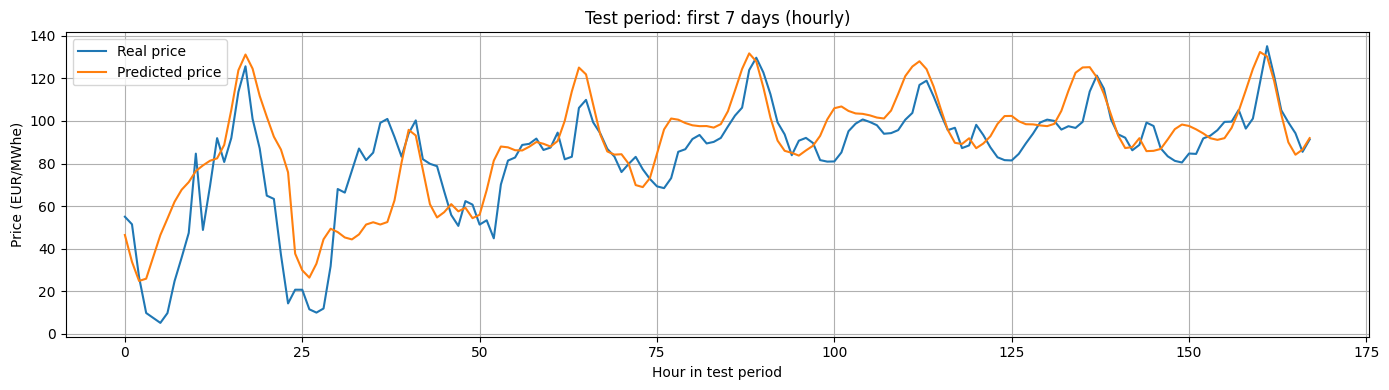

In [37]:
# 测试集前 7 天（7*24 点）
N_HOURS = 7 * 24
idx = np.arange(N_HOURS)

plt.figure(figsize=(14, 4))
plt.plot(idx, y_true_test[:N_HOURS], label="Real price")
plt.plot(idx, y_pred_test[:N_HOURS], label="Predicted price")
plt.xlabel("Hour in test period")
plt.ylabel("Price (EUR/MWhe)")
plt.title("Test period: first 7 days (hourly)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


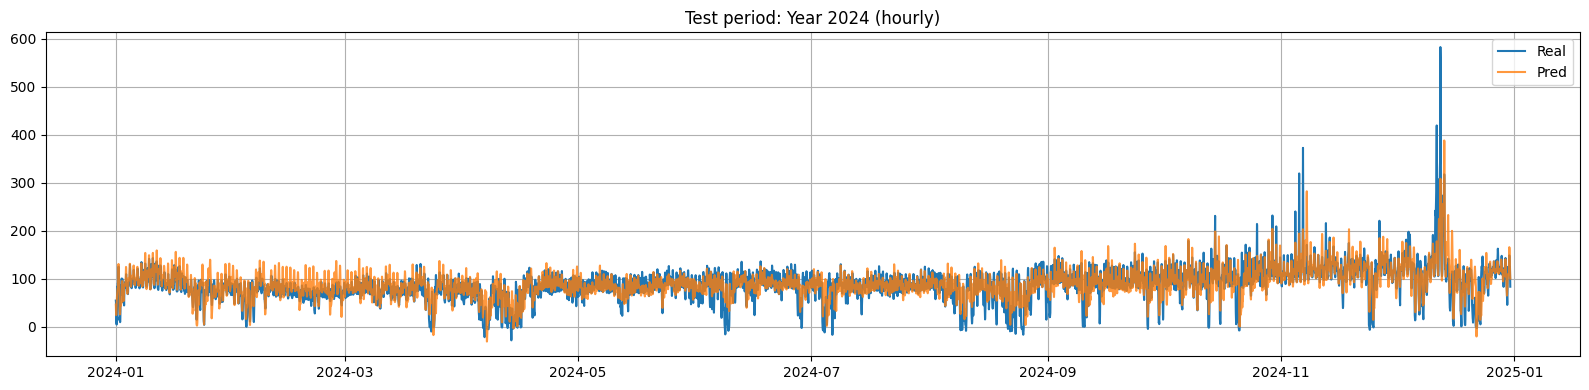

In [38]:
N_HOURS = 365 * 24
idx = np.arange(N_HOURS)
time_index = pd.date_range("2024-01-01 00:00", periods=len(y_true_test), freq="h")

plt.figure(figsize=(16, 4))
plt.plot(time_index[:N_HOURS], y_true_test[:N_HOURS], label="Real")
plt.plot(time_index[:N_HOURS], y_pred_test[:N_HOURS], label="Pred", alpha = 0.8)
plt.title("Test period: Year 2024 (hourly)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


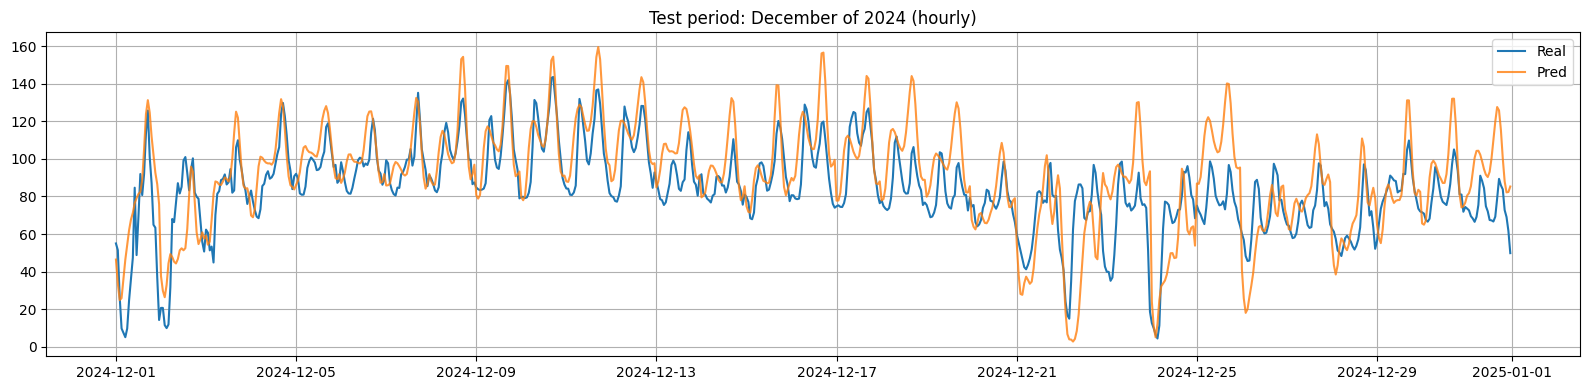

In [39]:
N_HOURS = 31 * 24
idx = np.arange(N_HOURS)
time_index = pd.date_range("2024-12-01 00:00", periods=len(y_true_test), freq="h")

plt.figure(figsize=(16, 4))
plt.plot(time_index[:N_HOURS], y_true_test[:N_HOURS], label="Real")
plt.plot(time_index[:N_HOURS], y_pred_test[:N_HOURS], label="Pred", alpha = 0.8)
plt.title("Test period: December of 2024 (hourly)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


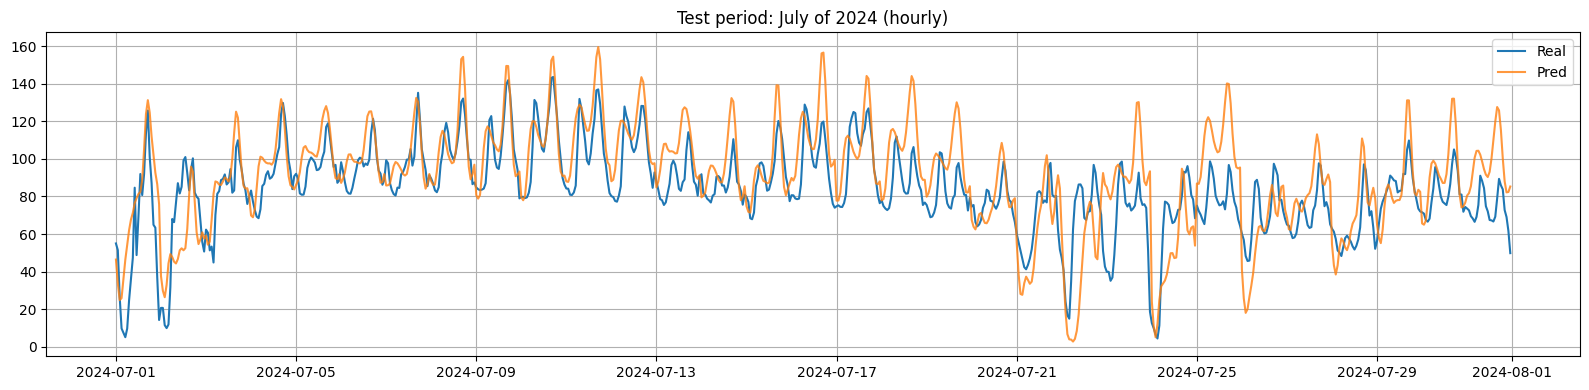

In [40]:
N_HOURS = 31 * 24
idx = np.arange(N_HOURS)
time_index = pd.date_range("2024-07-01 00:00", periods=len(y_true_test), freq="h")

plt.figure(figsize=(16, 4))
plt.plot(time_index[:N_HOURS], y_true_test[:N_HOURS], label="Real")
plt.plot(time_index[:N_HOURS], y_pred_test[:N_HOURS], label="Pred", alpha = 0.8)
plt.title("Test period: July of 2024 (hourly)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

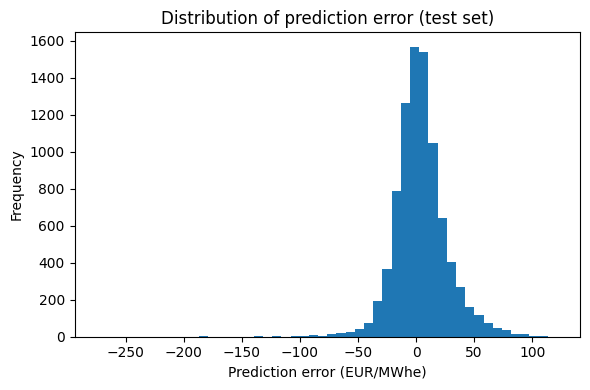

In [41]:
# 分布误差
errors = y_pred_test - y_true_test

plt.figure(figsize=(6, 4))
plt.hist(errors, bins=50)
plt.xlabel("Prediction error (EUR/MWhe)")
plt.ylabel("Frequency")
plt.title("Distribution of prediction error (test set)")
plt.tight_layout()
plt.show()

## forecasting

In [42]:
start_time = pd.Timestamp("2021-04-01 00:00:00")

df_raw = pd.read_csv("GB_df_features.csv")

df_raw["Datetime"] = pd.date_range(
    start=start_time,
    periods=len(df_raw),
    freq="H"         # 每一行对应一个小时
)

df_raw = df_raw.set_index("Datetime")
print(df_raw.head())
print(df_raw.tail())


                     Price (EUR/MWhe)  Price_lag_1h  Price_lag_2h  \
Datetime                                                            
2021-04-01 00:00:00             73.37         73.10         83.97   
2021-04-01 01:00:00             73.75         73.37         73.10   
2021-04-01 02:00:00             69.71         73.75         73.37   
2021-04-01 03:00:00             66.17         69.71         73.75   
2021-04-01 04:00:00             64.69         66.17         69.71   

                     Price_lag_23h  Price_lag_24h  Price_lag_13h  \
Datetime                                                           
2021-04-01 00:00:00          69.97          69.57          83.98   
2021-04-01 01:00:00          69.51          69.97          73.20   
2021-04-01 02:00:00          69.21          69.51          69.35   
2021-04-01 03:00:00          73.24          69.21          69.22   
2021-04-01 04:00:00          84.21          73.24          85.38   

                     Price_lag_22h  Pri

/var/folders/h1/ws83qjt554q7qtqbb482sgg40000gn/T/ipykernel_66222/3094515330.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_raw["Datetime"] = pd.date_range(


In [43]:
df_raw

,Price (EUR/MWhe),Price_lag_1h,Price_lag_2h,Price_lag_23h,Price_lag_24h,Price_lag_13h,Price_lag_22h,Price_lag_3h,Demand_lag_11h,UK_wind_Avg,hour_cos,hour_sin,dow_cos,dow_sin,month_sin,month_cos
Datetime,,,,,,,,,,,,,,,,
2021-04-01 00:00:00,73.37,73.10,83.97,69.97,69.57,83.98,69.51,87.22,30163.0,1.216390,1.000000,0.000000,-0.222521,-0.974928,5.000000e-01,-0.866025
2021-04-01 01:00:00,73.75,73.37,73.10,69.51,69.97,73.20,69.21,83.97,29858.0,1.246463,0.965926,0.258819,-0.222521,-0.974928,5.000000e-01,-0.866025
2021-04-01 02:00:00,69.71,73.75,73.37,69.21,69.51,69.35,73.24,73.10,29122.0,1.297512,0.866025,0.500000,-0.222521,-0.974928,5.000000e-01,-0.866025
2021-04-01 03:00:00,66.17,69.71,73.75,73.24,69.21,69.22,84.21,73.37,29350.0,1.375927,0.707107,0.707107,-0.222521,-0.974928,5.000000e-01,-0.866025
2021-04-01 04:00:00,64.69,66.17,69.71,84.21,73.24,85.38,99.54,73.75,30346.0,1.459317,0.500000,0.866025,-0.222521,-0.974928,5.000000e-01,-0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-30 17:00:00,132.86,145.60,149.14,116.06,122.93,94.08,109.91,141.23,23905.0,3.796390,0.258819,-0.965926,1.000000,0.000000,-2.449294e-16,1.000000
2024-11-30 18:00:00,125.77,132.86,145.60,109.91,116.06,109.97,93.62,149.14,26271.5,3.956317,0.500000,-0.866025,1.000000,0.000000,-2.449294e-16,1.000000
2024-11-30 19:00:00,125.60,125.77,132.86,93.62,109.91,125.07,87.97,145.60,27835.5,4.144146,0.707107,-0.707107,1.000000,0.000000,-2.449294e-16,1.000000


In [44]:
# 我们原来有 15 个特征：1 个 price + 15 个外生
cols = df_raw.columns.tolist()
target_col = cols[0]             # "Price (EUR/MWhe)"
exog_cols = cols[1:]             # 剩余 15 个

df_hist = df_raw.copy()

# 加入 month, weekday, hour 方便做 climatology
df_hist["month"] = df_hist.index.month
df_hist["weekday"] = df_hist.index.weekday
df_hist["hour"] = df_hist.index.hour

# climatology（2021–2024 的均值）
clim = df_hist.groupby(["month", "weekday", "hour"])[exog_cols].mean()

# 构造 2025 的索引
future_index = pd.date_range("2025-01-01 00:00:00", "2025-12-31 23:00:00", freq="h")

# 构造未来外生的 DataFrame
future_exog = pd.DataFrame(index=future_index, columns=exog_cols)
future_exog["month"] = future_exog.index.month
future_exog["weekday"] = future_exog.index.weekday
future_exog["hour"] = future_exog.index.hour

#future_exog = future_exog.join(clim, on=["month", "weekday", "hour"])[exog_cols]


In [45]:
future_exog

,Price_lag_1h,Price_lag_2h,Price_lag_23h,Price_lag_24h,Price_lag_13h,Price_lag_22h,Price_lag_3h,Demand_lag_11h,UK_wind_Avg,hour_cos,hour_sin,dow_cos,dow_sin,month_sin,month_cos,month,weekday,hour
2025-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,0
2025-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,1
2025-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,2
2025-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,3
2025-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,2,19
2025-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,2,20
2025-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,2,21
2025-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,2,22


In [62]:
base = pd.concat([df_raw, future_exog], axis=0).sort_index()

/var/folders/h1/ws83qjt554q7qtqbb482sgg40000gn/T/ipykernel_30947/1865820034.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  base = pd.concat([df_raw, future_exog], axis=0).sort_index()


/var/folders/h1/ws83qjt554q7qtqbb482sgg40000gn/T/ipykernel_66222/622272076.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_raw["Datetime"] = pd.date_range(
/var/folders/h1/ws83qjt554q7qtqbb482sgg40000gn/T/ipykernel_66222/622272076.py:38: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_index = pd.date_range("2025-01-01 00:00:00",


历史特征表：
                     Price (EUR/MWhe)  Price_lag_1h  Price_lag_2h  \
Datetime                                                            
2021-04-01 00:00:00             73.37         73.10         83.97   
2021-04-01 01:00:00             73.75         73.37         73.10   
2021-04-01 02:00:00             69.71         73.75         73.37   
2021-04-01 03:00:00             66.17         69.71         73.75   
2021-04-01 04:00:00             64.69         66.17         69.71   

                     Price_lag_23h  Price_lag_24h  Price_lag_13h  \
Datetime                                                           
2021-04-01 00:00:00          69.97          69.57          83.98   
2021-04-01 01:00:00          69.51          69.97          73.20   
2021-04-01 02:00:00          69.21          69.51          69.35   
2021-04-01 03:00:00          73.24          69.21          69.22   
2021-04-01 04:00:00          84.21          73.24          85.38   

                     Price_lag_2

,Price_forecast
2025-01-01 00:00:00,89.357918
2025-01-01 01:00:00,85.762962
2025-01-01 02:00:00,83.933800
2025-01-01 03:00:00,91.458008
2025-01-01 04:00:00,104.379585


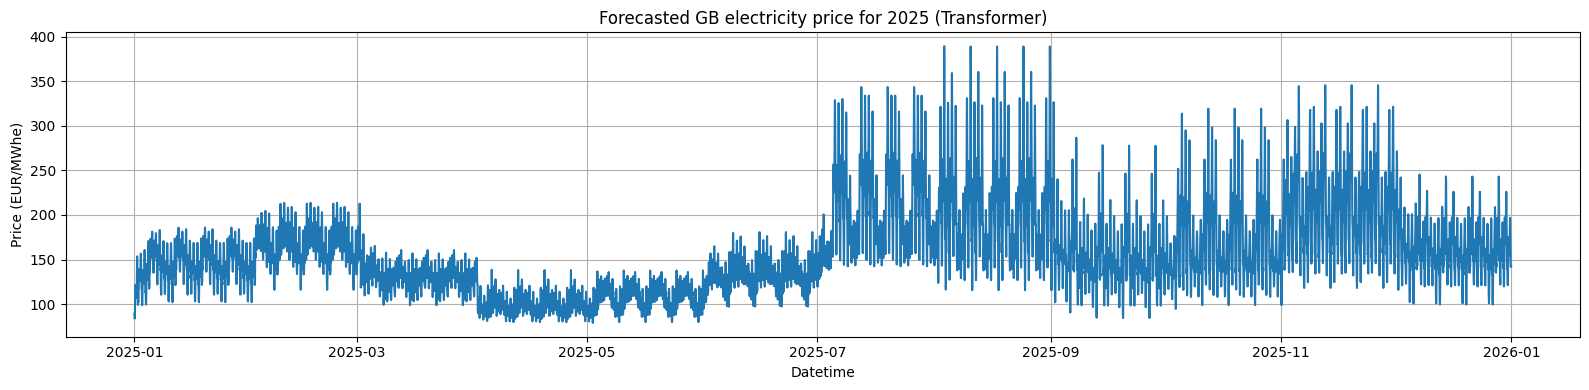

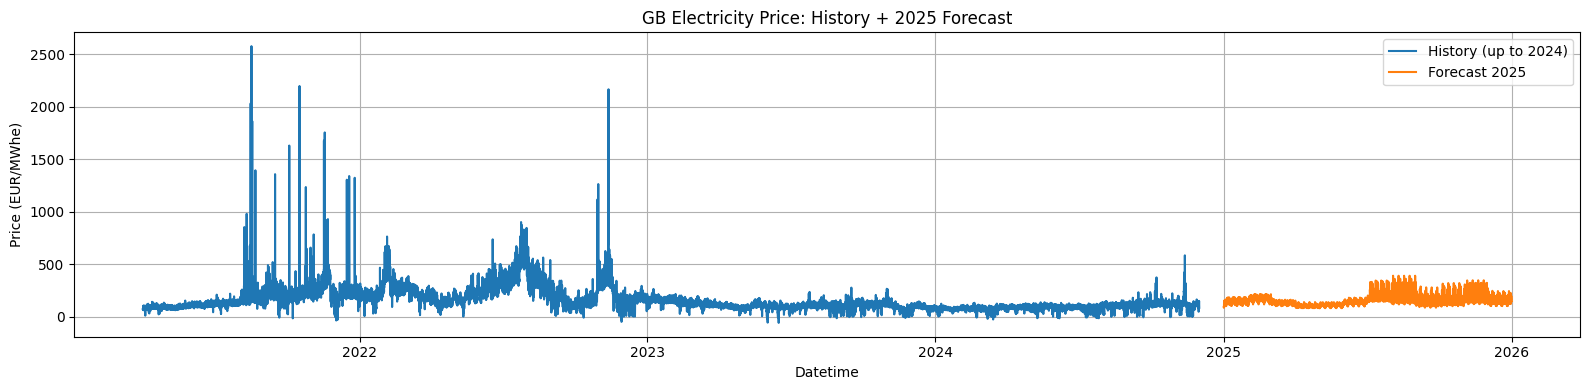

In [46]:
# =========================
# 6. Forecasting: 预测 2025 年电价
# =========================

# 6.1 把特征表重新加上 Datetime 索引（从 2021-04-01 开始，每小时一条）
start_time = pd.Timestamp("2021-04-01 00:00:00")

df_raw = pd.read_csv("GB_df_features.csv")
df_raw["Datetime"] = pd.date_range(
    start=start_time,
    periods=len(df_raw),
    freq="H"
)
df_raw = df_raw.set_index("Datetime")

print("历史特征表：")
print(df_raw.head())
print(df_raw.tail())

# 列名顺序与训练时完全一致：
# ['Price (EUR/MWhe)', 'Price_lag_1h', ..., 'month_cos']
cols = df_raw.columns.tolist()
target_col = cols[0]      # "Price (EUR/MWhe)"
exog_cols = cols[1:]      # 其余 15 个外生 / 滞后特征


# 6.2 用 2021–2024 的历史数据做 climatology，
#     给未来一年的外生特征（包括价格滞后特征）填入“典型值”
df_hist = df_raw.copy()
df_hist["month"] = df_hist.index.month
df_hist["weekday"] = df_hist.index.weekday
df_hist["hour"] = df_hist.index.hour

# 按 (month, weekday, hour) 求每个外生特征的平均值
clim = df_hist.groupby(["month", "weekday", "hour"])[exog_cols].mean()

# 未来一年的时间索引（你可以改成年份）
future_index = pd.date_range("2025-01-01 00:00:00",
                             "2025-12-31 23:00:00",
                             freq="H")

future_key = pd.DataFrame(index=future_index)
future_key["month"] = future_key.index.month
future_key["weekday"] = future_key.index.weekday
future_key["hour"] = future_key.index.hour

# 把 climatology 接到未来时间上，得到未来所有外生特征
future_exog = future_key.join(clim, on=["month", "weekday", "hour"])[exog_cols]

print("未来外生特征（climatology 填充）：")
print(future_exog.head())
print(future_exog.tail())


# 6.3 把历史数据和未来外生特征拼在一起
#     未来的电价列先用 NaN 占位，之后用模型预测值填
base = pd.concat([df_raw, future_exog], axis=0).sort_index()

# 确保列顺序与训练时一致
base = base[cols]

print("拼接后的总表（历史 + 未来外生）：")
print(base.tail())


# 6.4 使用训练集的均值和标准差做标准化
# means / stds 来自前面的 make_dataloaders_from_csv(...)
price_mean = float(means[target_col])
price_std = float(stds[target_col])

base_norm = (base - means) / stds   # 未来行有 NaN，但一开始不会取到它们


# 6.5 用滚动窗口（72 小时历史 → 未来 24 小时）逐日预测 2025 年
model.eval()

n_exog = len(exog_cols)
n_days_future = len(future_index) // 24        # 365 天
seq_len = SEQ_LEN                              # 72

forecast_prices = []                           # 存每个小时的预测（长度 8760）

# 找到 2025-01-01 00:00 在 base 里的整数位置
first_future_loc = base.index.get_loc(future_index[0])

for k in range(n_days_future):
    # 第 k 天的 24 小时起点（在 base 里的位置）
    horizon_start_pos = first_future_loc + 24 * k

    # 用它前面的 72 个小时作为历史窗口
    hist_start_pos = horizon_start_pos - seq_len
    hist_end_pos = horizon_start_pos           # 不包含 end

    if hist_start_pos < 0:
        raise ValueError("历史长度不够构造第一个预测窗口，请检查 SEQ_LEN 或数据长度。")

    # 取出标准化后的历史窗口 [seq_len, n_features]
    hist_window = base_norm.iloc[hist_start_pos:hist_end_pos]

    # 拆出模型需要的输入：values（价格）和 features（其余特征）
    values_np = hist_window[[target_col]].values          # [seq_len, 1]
    features_np = hist_window[exog_cols].values           # [seq_len, n_exog]

    values_t = torch.from_numpy(values_np).float().unsqueeze(0).to(device)   # [1, seq_len, 1]
    features_t = torch.from_numpy(features_np).float().unsqueeze(0).to(device)  # [1, seq_len, n_exog]

    with torch.no_grad():
        # 模型输出的是标准化空间中的 24 小时预测
        y_pred_norm = model(values_t, features_t)         # [1, 24]

    # 反标准化回真实电价
    y_pred_norm_np = y_pred_norm.cpu().numpy().reshape(-1)    # [24]
    y_pred_real = y_pred_norm_np * price_std + price_mean

    # 把这 24 小时的预测写回 base，用于后续天数的“历史价格序列”
    horizon_times = future_index[24 * k : 24 * (k + 1)]       # 当天 24 个时间点
    base.loc[horizon_times, target_col] = y_pred_real

    # 同步更新标准化表里的价格列（其余外生特征仍用 climatology）
    base_norm.loc[horizon_times, target_col] = (y_pred_real - price_mean) / price_std

    # 记录预测结果
    forecast_prices.extend(y_pred_real.tolist())

forecast_prices = np.array(forecast_prices)
print("一共预测小时数：", len(forecast_prices))  # 应该是 8760


# 6.6 把 2025 年预测结果整理成 DataFrame 并画图
forecast_df = pd.DataFrame(
    index=future_index,
    data={"Price_forecast": forecast_prices}
)

display(forecast_df.head())

plt.figure(figsize=(16, 4))
plt.plot(forecast_df.index, forecast_df["Price_forecast"])
plt.title("Forecasted GB electricity price for 2025 (Transformer)")
plt.xlabel("Datetime")
plt.ylabel("Price (EUR/MWhe)")
plt.grid(True)
plt.tight_layout()
plt.show()


# 6.7 如果想把 2024 + 2025 连在一起看：
hist_price = df_raw[target_col].copy()
full_series = pd.concat(
    [hist_price, forecast_df["Price_forecast"].rename("Price_forecast_2025")],
    axis=1
)

plt.figure(figsize=(16, 4))
plt.plot(full_series.index, full_series.iloc[:, 0], label="History (up to 2024)")
plt.plot(forecast_df.index, forecast_df["Price_forecast"], label="Forecast 2025")
plt.legend()
plt.xlabel("Datetime")
plt.ylabel("Price (EUR/MWhe)")
plt.title("GB Electricity Price: History + 2025 Forecast")
plt.grid(True)
plt.tight_layout()
plt.show()


In [47]:
forecast_df

,Price_forecast
2025-01-01 00:00:00,89.357918
2025-01-01 01:00:00,85.762962
2025-01-01 02:00:00,83.933800
2025-01-01 03:00:00,91.458008
2025-01-01 04:00:00,104.379585
...,...
2025-12-31 19:00:00,155.650040
2025-12-31 20:00:00,145.137039
2025-12-31 21:00:00,141.845596
2025-12-31 22:00:00,142.762711
